In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm
from datetime import datetime
from os import path
import os
import sklearn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

data = pd.read_csv('fer2013.csv')
pixels = data['pixels'].tolist()
width, height = 48, 48
faces = []
print(data.info())
print(data.head(7))

for pixel_sequence in pixels:
    face = [int(pixel) for pixel in pixel_sequence.split(' ')]
    face = np.asarray(face).reshape(width, height)
    faces.append(face.astype('float32'))

faces = np.asarray(faces)
faces = np.expand_dims(faces, -1)

# Normalize the pixels
faces /= 255.0

# Emotion labels
emotions = pd.get_dummies(data['emotion']).values

# Convert to PyTorch tensors
X = torch.tensor(faces, dtype=torch.float32)
y = torch.tensor(emotions, dtype=torch.long)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB
None
   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training
5        2  55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...  Training
6        4  20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...  Training


In [10]:
# Définissez les paramètres d'entraînement
batch_size = 47
lr = 0.001
epochs = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
# Définir la régularisation L2
l2_reg = 0.01

# Créez une instance de modèle
class EmotionRecognitionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout):
        super(EmotionRecognitionModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.hidden_layer = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        x = x.view(-1, self.input_dim)
        x = self.input_layer(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.hidden_layer(x)
        return x
    

def fit(model, X_train, y_train, X_val=None, y_val=None, epochs=10, batch_size=32, lr=0.01, verbose=True):
    train_dataset = TensorDataset(torch.tensor(X_train.reshape(-1, model.input_dim)), torch.tensor(y_train))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    if X_val is not None and y_val is not None:
        val_dataset = TensorDataset(torch.tensor(X_val.reshape(-1, model.input_dim)), torch.tensor(y_val))
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    for epoch in tqdm(range(epochs), desc="Traitement en cours", bar_format="{l_bar}{bar:10}{r_bar}"):
        # Training loop
        train_loss = 0.0
        train_acc = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch.float())
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += accuracy_score(y_batch, y_pred.argmax(dim=1))
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        
        # Validation loop
        if X_val is not None and y_val is not None:
            val_loss = 0.0
            val_acc = 0.0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    y_pred = model(X_batch.float())
                    loss = criterion(y_pred, y_batch)
                    val_loss += loss.item()
                    val_acc += accuracy_score(y_batch, y_pred.argmax(dim=1))
                
            val_loss /= len(val_loader)
            val_acc /= len(val_loader)
            val_loss_history.append(val_loss)
            val_acc_history.append(val_acc)
        
        if verbose:
            if X_val is not None and y_val is not None:
                print(f'Epoch {epoch+1}/{epochs}, "\n", Train Loss: {train_loss:.4f}, Train Accuracy : {train_acc:.4f}, "\n" , Val Loss: {val_loss:.4f}, Val Accuracy : {val_acc:.4f}')
            else:
                print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}')

    
    if X_val is not None and y_val is not None:
        return train_loss_history, train_acc_history, val_loss_history, val_acc_history
    else:
        return train_loss_history, train_acc_history
    
def predict(model, X):
    dataset = TensorDataset(torch.tensor(X))
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    y_pred = []
    with torch.no_grad():
        for X_batch in loader:
            batch_pred = model(X_batch.float())
            y_pred.append(batch_pred)
    return torch.cat(y_pred, dim=0).numpy()


In [11]:
######################################### -----------------------ENTRAINEMENT NORMAL---------------------##########################""
from tqdm import tqdm

input_dim = X.shape[1] # number of input features
hidden_dim = 64 # number of neurons in the hidden layer
output_dim = len(set(y)) # number of output classes
lr= 0.01
dropout = 0.5
batch_size = 32

from sklearn.model_selection import train_test_split

# Diviser les données en ensembles d'entraînement et de test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train.reshape(-1, 2304), dtype=torch.float32) # flatten last three dimensions
X_val = torch.tensor(X_val.reshape(-1, 2304), dtype=torch.float32) # flatten last three dimensions


y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)


# PAS NECESSAIRE
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# Entraîner le modèle
model = EmotionRecognitionModel(input_dim=X_train.shape[1], hidden_dim=hidden_dim, output_dim=output_dim, dropout=0.2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=l2_reg)

train_loss_history, train_acc_history, val_loss_history, val_acc_history = fit(model, X_train, y_train, X_val=X_val, y_val=y_val, epochs=10, batch_size=batch_size, lr=lr, verbose=True)

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_5508\333657380.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train.reshape(-1, 2304), dtype=torch.float32) # flatten last three dimensions
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_5508\333657380.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val.reshape(-1, 2304), dtype=torch.float32) # flatten last three dimensions
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_5508\333657380.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourc

Epoch 1/10, "
", Train Loss: 2.0755, Train Accuracy : 0.2136, "
" , Val Loss: 2.0168, Val Accuracy : 0.2425


Traitement en cours:  20%|██        | 2/10 [02:31<10:27, 78.40s/it]

Epoch 2/10, "
", Train Loss: 1.8912, Train Accuracy : 0.2529, "
" , Val Loss: 1.8150, Val Accuracy : 0.2610


Traitement en cours:  30%|███       | 3/10 [03:50<09:08, 78.32s/it]

Epoch 3/10, "
", Train Loss: 1.7857, Train Accuracy : 0.2833, "
" , Val Loss: 1.7748, Val Accuracy : 0.2808


Traitement en cours:  40%|████      | 4/10 [05:08<07:49, 78.33s/it]

Epoch 4/10, "
", Train Loss: 1.7679, Train Accuracy : 0.2884, "
" , Val Loss: 1.7587, Val Accuracy : 0.2907


Traitement en cours:  50%|█████     | 5/10 [06:30<06:38, 79.60s/it]

Epoch 5/10, "
", Train Loss: 1.7719, Train Accuracy : 0.2847, "
" , Val Loss: 1.7765, Val Accuracy : 0.2725


Traitement en cours:  60%|██████    | 6/10 [08:02<05:35, 83.97s/it]

Epoch 6/10, "
", Train Loss: 1.7726, Train Accuracy : 0.2845, "
" , Val Loss: 1.7784, Val Accuracy : 0.2870


Traitement en cours:  70%|███████   | 7/10 [09:26<04:11, 83.99s/it]

Epoch 7/10, "
", Train Loss: 1.7814, Train Accuracy : 0.2773, "
" , Val Loss: 1.7868, Val Accuracy : 0.2670


Traitement en cours:  80%|████████  | 8/10 [10:57<02:52, 86.25s/it]

Epoch 8/10, "
", Train Loss: 1.7924, Train Accuracy : 0.2680, "
" , Val Loss: 1.8085, Val Accuracy : 0.2500


Traitement en cours:  90%|█████████ | 9/10 [12:33<01:29, 89.12s/it]

Epoch 9/10, "
", Train Loss: 1.8050, Train Accuracy : 0.2576, "
" , Val Loss: 1.8107, Val Accuracy : 0.2467


Traitement en cours: 100%|██████████| 10/10 [13:56<00:00, 83.68s/it]

Epoch 10/10, "
", Train Loss: 1.8095, Train Accuracy : 0.2545, "
" , Val Loss: 1.8093, Val Accuracy : 0.2467


Taille de l'ensemble d'entraînement: 28709
Taille de l'ensemble de validation: 7178


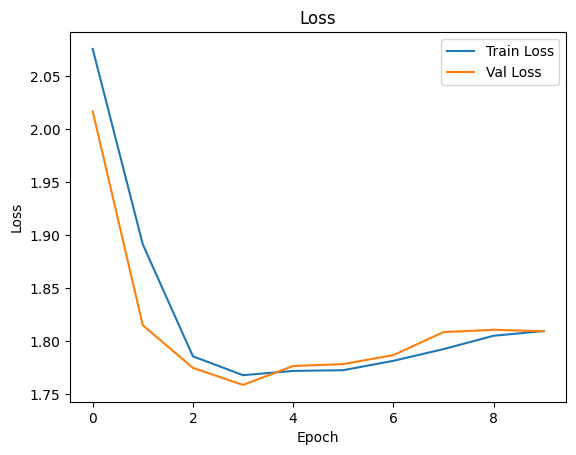

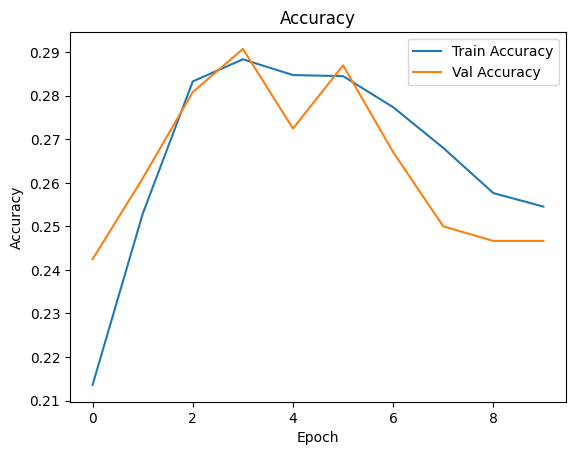

In [13]:
import matplotlib.pyplot as plt


print('Taille de l\'ensemble d\'entraînement:', len(X_train))
print('Taille de l\'ensemble de validation:', len(X_val))

# Tracer la courbe de perte
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Tracer la courbe d'accuracy
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Val Accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

On recherche les hyperparametre grace a la librairie optuna

In [15]:
import optuna
from optuna import Trial


# A VOIR COMMENT FONCTIONNE OPTUNA EN DETAIL 


# Convertir les étiquettes en vecteurs one-hot
y_train = np.eye(7)[y_train]
y_val = np.eye(7)[y_val]

# Convertir les vecteurs one-hot en entiers
y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)

y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)


# Définir la fonction objectif à minimiser
def objective(trial: Trial, X_train, y_train, X_val, y_val):
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    l2_reg = trial.suggest_loguniform('l2_reg', 1e-10, 1e-3)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256])

    # Entraîner le modèle avec les hyperparamètres suggérés par Optuna
    model = EmotionRecognitionModel(input_dim=X_train.shape[1], hidden_dim=hidden_size, output_dim=output_dim, dropout=0.2)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=l2_reg)
    
    train_loss_history, train_acc_history, val_loss_history, val_acc_history = fit(model, X_train, y_train, X_val=X_val, y_val=y_val, epochs=10, batch_size=batch_size, lr=lr, verbose=True)


study = optuna.create_study()
lr, l2_reg, batch_size, hidden_size = study.optimize(objective(X_train, y_train, X_val, y_val), n_trials=10)


    

c:\Users\Utilisateur\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


On entraine le modele avec les meilleurs hyperparametres tourvé

In [ ]:
model = EmotionRecognitionModel(input_dim=X_train.shape[1], hidden_dim=hidden_dim, output_dim=output_dim, dropout=0.2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=l2_reg)

train_loss_history_hp, train_acc_history_hp, val_loss_history_hp, val_acc_history_hp = fit(model, X_train, y_train, X_val=X_val, y_val=y_val, epochs=10, batch_size=batch_size, lr=lr, verbose=True)
 

Comparaison des modele sur le set de validation

In [ ]:
# Tracer la courbe de perte
plt.plot(val_loss_history_hp, label='HP Val loss')
plt.plot(val_loss_history, label='Val Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Tracer la courbe d'accuracy
plt.plot(val_acc_history_hp, label='HP Val Accuracy')
plt.plot(val_acc_history, label='Val Accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()
